In [20]:
import IP.basic_ip as IP
import IP.morphological_edge_detection as IP_med
import numpy as np
from skimage.color import rgb2gray
import skimage.filters as flt
from scipy import ndimage

#init variables:
edges=[]
labels=[]
objects=[]
nb_objects=np.array([0,0,0])
detected_objects_img=[]

#contour extraction params:
channel=1 #Green
nb_img=images.shape[0]

G_t1=0.09
G_t2=1
thresholding=False
smoothin_sigma=1

#extract objects params:
contour_label=0.0 #if this label: is is contour

#classify params
#note that blue has greater intensity in B channel and black/white is kinda homogeneous
eps_black=20 #if channel values are in relative range: is black
background_limit=5000 #if greater than this limit: is background
form_limit=100 #if smaller than this limit: is noise

print_full_analysis=False

#img analysis algorithm:
for i in range(nb_img):
    #contour extraction:
    img=images[i]
    img=IP.minmax(img[:,:,channel],255) #normalize image minmax to [0,255]
    (temp,_,_,_,_)=IP_med.skeletonize_based_sobel(img,smoothin_sigma,0,0,G_t1,G_t2,thresholding)
    edges.append(temp)
    
    #labelize:
    edgeMap=edges[i]
    edgeMap = -np.array(edgeMap).astype(int) #convert edges to negative values
    temp = labelizePixels(edgeMap)
    labels.append(temp)

    unique_labels=np.unique(labels[i])
    
    #normalize img minmax:
    img=images[i]
    img=np.dstack((IP.minmax(img[:,:,0],255),IP.minmax(img[:,:,1],255),IP.minmax(img[:,:,2],255)))
    
    #object extraction:
    #prepare image for overlaying cross at object position
    img_cross_overlay=img.copy()
    
    #get for each label its object data
    for j,label in enumerate(unique_labels):
        #pixels of object
        label_idx=labels[i]==label
        
        COM=ndimage.measurements.center_of_mass(label_idx.astype(int))
        
        extracted_form=img[label_idx,:]
        nb_px=extracted_form.shape[0]
        average_color=np.sum(extracted_form,0)/nb_px
        
        objects.append((average_color,nb_px,COM,label))
        nb_objects[i]=j+1
        
        if label!=contour_label:
            img_cross_overlay=IP.overlay_cross(img_cross_overlay,COM,cross_size=20)
        
    detected_objects_img.append(img_cross_overlay)

    #classify based on color thresholding:
    #numeration logic of stored objects
    if i==0:
        idx_shift=0
    else:
        idx_shift+=nb_objects[i-1]
        
    print("Image %d:" %(i+1))
    
    #count features
    nb_blue=0
    nb_black=0
    noise=0
    background=0
    
    for j in range(nb_objects[i]):
        (average_color,shape_size,COM,label)=objects[idx_shift+j]
        #classify
        if shape_size>background_limit:
            objects[idx_shift+j]=(average_color,shape_size,COM,label,"background")
            background+=1
        elif shape_size<form_limit:
            objects[idx_shift+j]=(average_color,shape_size,COM,label,"noise")
            noise+=1
        elif label==contour_label:
            objects[idx_shift+j]=(average_color,shape_size,COM,label,"contour")
        elif average_color[0]-eps_black<average_color[1]<average_color[0]+eps_black and average_color[0]-eps_black<average_color[2]<average_color[0]+eps_black:
            objects[idx_shift+j]=(average_color,shape_size,COM,label,"black")
            nb_black+=1
        else:
            objects[idx_shift+j]=(average_color,shape_size,COM,label,"blue")
            nb_blue+=1
        
        if print_full_analysis:
            print(objects[idx_shift+j])
        
    print("bkgnd: %d, noise: %d, blue: %d, black: %d" %(background,noise,nb_blue,nb_black),"\n\n")
        
            
        
        


Image 1:
bkgnd: 1, noise: 1, blue: 5, black: 5 


Image 2:
bkgnd: 1, noise: 4, blue: 5, black: 5 


Image 3:
bkgnd: 1, noise: 1, blue: 5, black: 5 




In [ ]:
#NEW FUCTION TO ADD
def overlay_cross(img,cross_pos,cross_colour=[255,0,0],cross_size=11):
    
    if not cross_size%2: #if even make it odd!
        cross_size+=1
    
    mid=int(cross_size/2)
    
    nx,ny,nz=img.shape
    out=img.astype(int)
    (x,y)=cross_pos
    x=int(x)
    y=int(y)
    
    for i in range(cross_size):
        idx_x=x-mid+i
        idx_y=y-mid+i
        
        if idx_y<0:
            idx_y=0
        elif idx_y>=ny:
            idx_y=ny
            
        if idx_x<0:
            idx_x=0
        elif idx_x>=nx:
            idx_x=nx
        
        out[idx_x][y][0]=cross_colour[0]
        out[idx_x][y][1]=cross_colour[1]
        out[idx_x][y][2]=cross_colour[2]
        
        out[x][idx_y][0]=cross_colour[0]
        out[x][idx_y][1]=cross_colour[1]
        out[x][idx_y][2]=cross_colour[2]
        
    return out

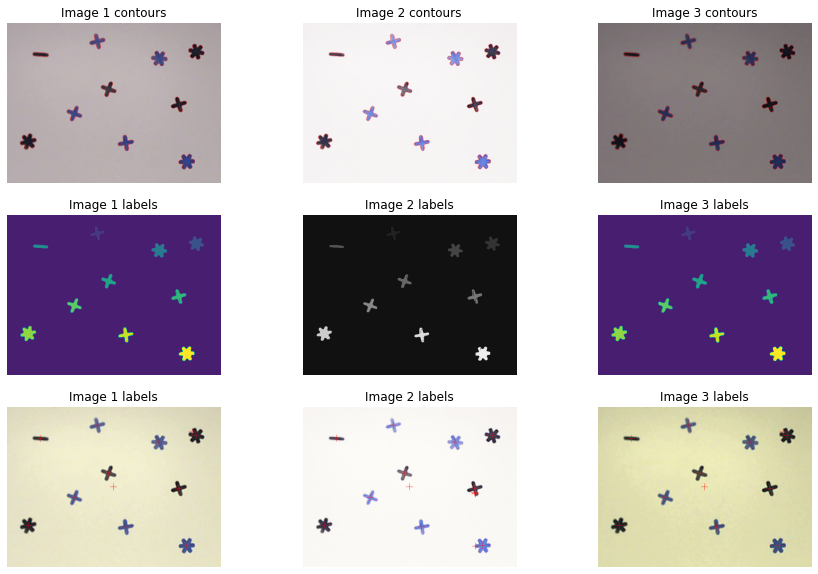

In [21]:
#plot result
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax[0][0].imshow(IP.overlay_contours(images[0],edges[0]))
ax[0][0].set_title('Image 1 contours')
ax[0][0].axis('off')

ax[0][1].imshow(IP.overlay_contours(images[1],edges[1]))
ax[0][1].set_title('Image 2 contours')
ax[0][1].axis('off')

ax[0][2].imshow(IP.overlay_contours(images[2],edges[2]))
ax[0][2].set_title('Image 3 contours')
ax[0][2].axis('off')

ax[1][0].imshow(labels[0])
ax[1][0].set_title('Image 1 labels')
ax[1][0].axis('off')

ax[1][1].imshow(labels[1],cmap='gray')
ax[1][1].set_title('Image 2 labels')
ax[1][1].axis('off')

ax[1][2].imshow(labels[2])
ax[1][2].set_title('Image 3 labels')
ax[1][2].axis('off')

ax[2][0].imshow(detected_objects_img[0])
ax[2][0].set_title('Image 1 labels')
ax[2][0].axis('off')

ax[2][1].imshow(detected_objects_img[1])
ax[2][1].set_title('Image 2 labels')
ax[2][1].axis('off')

ax[2][2].imshow(detected_objects_img[2])
ax[2][2].set_title('Image 3 labels')
ax[2][2].axis('off')
plt.show()